The goal of this notebook is to illustrate changes in concentration in two well-mixed compartments connected by a channel. The channel abides a Nernst relationship[ to determine the conductance ]

In [1]:
# Function for integreating ODE and displaying results
import scipy.integrate
from scipy.integrate import odeint
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
def f(y,t,a):
    dydt = -a   # *y[0]
    return dydt

def f2(y,t,a):
    y0 = .1 # [uM]
    funFactor = 5.
    dydt = -phyTT * funFactor * np.log(y[0]/y0)   # *y[0]
    dydt += 0.0 # for source
    return dydt

# phi cyto
phiCyto = 0.1 # uM/ms
VCyto =1.  #
VTT = .1 # pL

# points in time where the function gets evaluated, t[0] at y0
t  = scipy.linspace(0.,500.,201) # ms
# init conc
y0 = [2000.] # [uM]

# rate
phyTT = phiCyto * VCyto/VTT #  uM/ms
y = scipy.integrate.odeint(f,y0,t,args=(phyTT,))
y2 = scipy.integrate.odeint(f2,y0,t,args=(phyTT,))

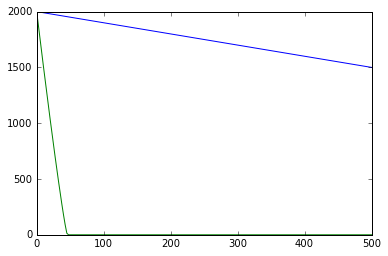

In [3]:
plt.plot(t,y)
plt.plot(t,y2)
#plt.ylim([1900,2100])

In [4]:
np.log(2000/0.1)

9.9034875525361272

Let's add some physical relationships
- Let's assume that 
$$n_{TT}V_{TT}=V_{cell}$$, 
where the LHS n and V represent the number of TTs and cytosolic volume about a single TT
- We can determine the rate of concentration change inside the cell, $\phi$, via the relationship
$$
\begin{align}
\phi_{cell} &= \frac{I}{2FV} \\
\end{align}
$$
We'll use $\phi=$7e-2 [uM/ms] from my lecture notes math, using I=400 pA, V = 30 pL
- Assuming $\phi$ is uniform, the corresponding current from a single TT is therefore given by
$$
\begin{align}
\phi_{TT} &= \phi_{cell}\\
\frac{I_{TT}}{zFV_{TT}} &= \frac{I_{cell}}{zFV_{cell}} \\
\Rightarrow I_{TT} &= I_{cell} \frac{V_{TT}}{V_{cell}}
\end{align}
$$
This evalutes to $I_{TT}=$4e-4 [pA], assuming there are 10e5 TTs
- We can determine the corresponding surface flux along the TT boundary, and specifically at the LCC cluster, $\Gamma_L$, using
$$
\begin{align}
\int_{V_{tt}} \phi dV&= \int_{\Gamma_{L}} \nabla\phi d\Gamma \\
\Rightarrow V_{tt} \phi &= i_{L} \Gamma_L
\end{align}
$$
Assuming a circular release patch of radius 50 nm, $i_{LCC}=$ 280 [uM nm/ms]. Note that this last quantity can be used to define the flux amplitude in FEM simulations

#### First let's demonstrate that we can predict conc changes for constant ilcc

942477.796077
[0.00025, -0.007957747154594767]


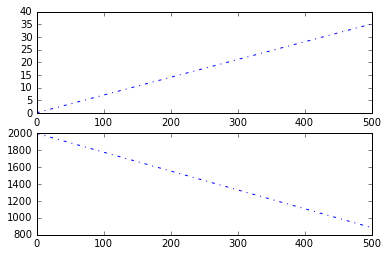

In [104]:
saTT = 7500. # nm**2
vTT = 3e7 # volume of cytosol around TT nm**3
wTT = 100 # radius nm
heightTT = 3e3 # height nm
viTT = np.pi * heightTT * wTT # vol inside TT nm**2
print viTT
iCellMax = 400 # pA
iTTmax = 280. # uM nm / ms
cCyto = 0.1 # uM
cTT = 2e3 # uM
def i_to_phi(iTT):
    phi = iTT * saTT / vTT
    return phi


def fConstant_iTT(yi,t,iTT):
    phi = i_to_phi(iTT)
    phiTT = -phi * vTT / viTT
    dydt = [phi,phiTT]
    #print dydt
    return dydt

# points in time where the function gets evaluated, t[0] at y0
t  = scipy.linspace(0.,500.,201) # ms
# init conc [cytosol]
y0 = [cCyto,cTT] # [uM]
print fConstant_iTT(y0,0,1)
# rate
#phyTT = phiCyto * VCyto/VTT #  uM/ms
iTT = iTTmax
y = scipy.integrate.odeint(fConstant_iTT,y0,t,args=(iTT,))

plt.subplot(211)
plt.plot(t,y[:,0],'-.',label="cyto")
plt.subplot(212)
plt.plot(t,y[:,1],'-.',label="inner TT")


### define LCC flux

In [120]:
I_to_ilcc = iTTmax*saTT
RT_o_zF = 12.5 # mV
gCond = iTTmax/(RT_o_zF * np.log(cCyto/cTT))
V = 0. # mV
#print gCond
def f_ilcc(cCyto,cTT):
    ilcc = -gCond * RT_o_zF * (V-np.log(cCyto/cTT))   # *y[0]
    ilcc = np.max([0,ilcc])
    return ilcc


print f_ilcc(cCyto,cTT) # init cond
print f_ilcc(cCyto,cTT/2.) # reduced cTT


#plt.plot( f_ilcc(0.1,y[:,1]) )


280.0
260.402741001


### Now use LCC flux in ODE
Note that the concs in cyto/TT don't change as much (since iLCC is reducing)

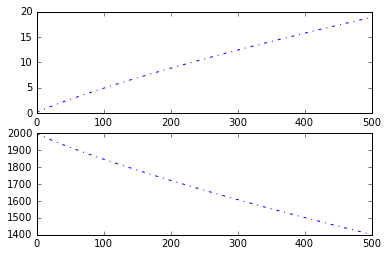

In [121]:
def fVariable_iTT(yi,t):#,iTT):
    cCyto,cTT = yi
    iTT = f_ilcc(cCyto,cTT)
    phi = i_to_phi(iTT)
    phiTT = -phi * vTT / viTT
    dydt = [phi,phiTT]
    #print dydt
    return dydt

# points in time where the function gets evaluated, t[0] at y0
t  = scipy.linspace(0.,500.,201) # ms
# init conc [cytosol]
y0 = [cCyto,cTT] # [uM]
# rate
#phyTT = phiCyto * VCyto/VTT #  uM/ms

y = scipy.integrate.odeint(fVariable_iTT,y0,t)#,args=(iTT,))

plt.subplot(211)
plt.plot(t,y[:,0],'-.',label="cyto")
plt.subplot(212)
plt.plot(t,y[:,1],'-.',label="inner TT")


### Relate iLCC to whole-cell current 

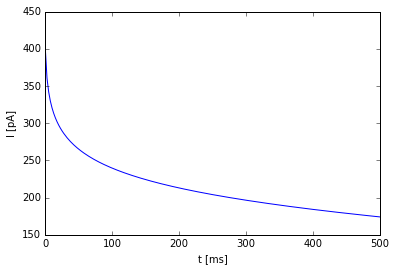

In [122]:
ilcc_to_Icell = iCellMax/ iTTmax
#print ilcc_to_Icell * iTTmax

# dumb hack for calculating i at each time step
#g = lambda x: vf_ilcc(x[0],x[1])
def evalLCC(y):
    ilccs = []
    for i,yi in enumerate(y):
      cCyto,cTT = yi  
      ilccT = f_ilcc(cCyto,cTT)
      ilccs.append(ilccT)  
      #print cCyto, cTT
    ilccs = np.asarray(ilccs)    
    #print np.shape(ilccs)
    return ilccs
ilccs = evalLCC(y)

#plt.plot(t,ilccs)
#plt.figure()
plt.plot(t,ilccs*ilcc_to_Icell)
plt.ylabel("I [pA]")
plt.xlabel("t [ms]")

### To search for a good intraTT volume (e.g. slow domain volume)

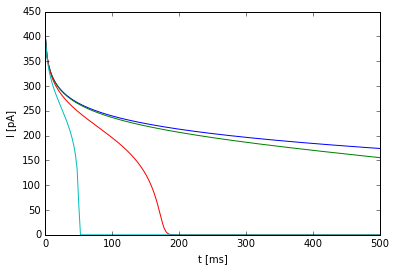

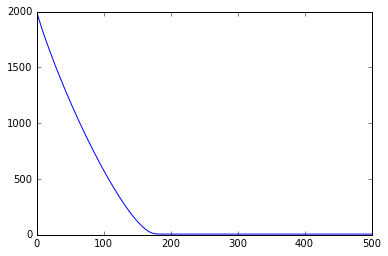

In [125]:
def fVariable_iTT_Vol(yi,t,viTT):
    cCyto,cTT = yi
    iTT = f_ilcc(cCyto,cTT)
    phi = i_to_phi(iTT)
    phiTT = -phi * vTT / viTT
    dydt = [phi,phiTT]
    #print dydt
    return dydt

def fVariable_iTT_Vol_FixedCai(yi,t,viTT):
    cCyto,cTT = yi
    iTT = f_ilcc(0.1,cTT)
    phi = i_to_phi(iTT)
    phiTT = -phi * vTT / viTT
    dydt = [phi,phiTT]
    #print dydt
    return dydt

# points in time where the function gets evaluated, t[0] at y0
t  = scipy.linspace(0.,500.,201) # ms
# init conc [cytosol]
y0 = [cCyto,cTT] # [uM]

#####
##
viTT_trial = viTT * 1. 
y1 = scipy.integrate.odeint(fVariable_iTT_Vol,y0,t,args=(viTT_trial,))
ilccs = evalLCC(y1)
plt.plot(t,ilccs*ilcc_to_Icell)
##
viTT_trial = viTT * 0.5
y2 = scipy.integrate.odeint(fVariable_iTT_Vol,y0,t,args=(viTT_trial,))
ilccs = evalLCC(y2)
plt.plot(t,ilccs*ilcc_to_Icell)

##
viTT_trial = viTT * 0.1
y2 = scipy.integrate.odeint(fVariable_iTT_Vol,y0,t,args=(viTT_trial,))
ilccs = evalLCC(y2)
plt.plot(t,ilccs*ilcc_to_Icell)

##
viTT_trial = viTT * 0.05
y3 = scipy.integrate.odeint(fVariable_iTT_Vol_FixedCai,y0,t,args=(viTT_trial,))
ilccs = evalLCC(y3)
plt.plot(t,ilccs*ilcc_to_Icell)

plt.ylabel("I [pA]")
plt.xlabel("t [ms]")
plt.figure()
plt.plot(t,y2[:,1])

Note that the last one probably had an instability, since at some point the intraTT conc--> 0

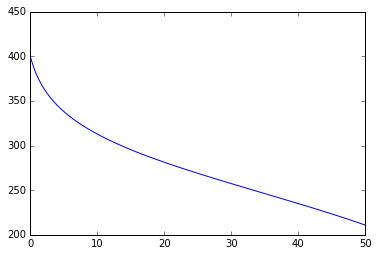

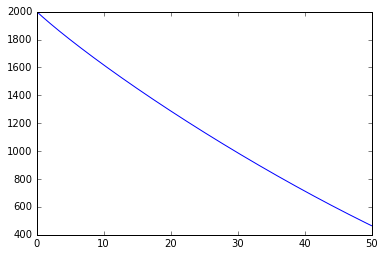

In [116]:
# Make finer resolution
t  = scipy.linspace(0.,50.,2001) # ms
# init conc [cytosol]
y0 = [cCyto,cTT] # [uM]

#####
##
viTT_trial = viTT * .05 
yi = scipy.integrate.odeint(fVariable_iTT_Vol,y0,t,args=(viTT_trial,))
ilccs = evalLCC(yi)
plt.plot(t,ilccs*ilcc_to_Icell)
plt.figure()
plt.plot(t,yi[:,1])